In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# Data extracted from Prop Hero database

price_sqm = pd.read_excel('C:/Users/User/Desktop/SP Data - PropHero (2).xlsx', sheet_name=3)
rent_sqm = pd.read_excel('C:/Users/User/Desktop/SP Data - PropHero (2).xlsx', sheet_name=4)
time2sell = pd.read_excel('C:/Users/User/Desktop/SP Data - PropHero (2).xlsx', sheet_name=5)
time2rent = pd.read_excel('C:/Users/User/Desktop/SP Data - PropHero (2).xlsx', sheet_name=6)
default_risk = pd.read_excel('C:/Users/User/Desktop/SP Data - PropHero (2).xlsx', sheet_name=7)
housing_transactions = pd.read_excel('C:/Users/User/Desktop/SP Data - PropHero (2).xlsx', sheet_name=8)

# Functions

In [9]:
def convert_column_name(column_name):
    year, quarter = column_name.split('Q')
    year_month = f"{year}-{(int(quarter) - 1) * 3 + 1:02d}"
    return year_month

def calculate_cagr(group, periods):
    return (group / group.shift(periods)) ** (1 / (periods / 4)) - 1

def long_dataframe(df, value_name, keep_columns):
    """
    Transform the DataFrame to a long format, keep only specified columns, and apply additional transformations.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to be transformed.
    - value_name (str): The name to be used for the value column in the melted DataFrame.
    - keep_columns (list): List of columns to keep in the final DataFrame.
    
    Returns:
    - pd.DataFrame: The transformed DataFrame in long format.
    """
    # Identify non-date columns
    non_date_columns = [col for col in df.columns if not col.startswith('2')]

    # Melt the DataFrame
    df_melted = pd.melt(df, id_vars=non_date_columns, var_name='Date', value_name=value_name)
    
    # Set and sort index
    df_melted = (df_melted.set_index(['Date', 'Province_Name'])
                      .reset_index()
                      .set_index('Date')
                      .sort_index(ascending=True))

    # Convert index to datetime
    df_melted.index = pd.to_datetime(df_melted.index)
    
    # Apply specific filter, here filtering out rows with 'Max month' < 2007
    # Ensure 'Max month' column exists; if not, adjust the condition or remove
    if 'Max month' in df_melted.columns:
        df_melted = df_melted[df_melted['Max month'] < 2014]

    # Keep only specified columns if they exist
    df_melted = df_melted[[col for col in keep_columns if col in df_melted.columns]]

    return df_melted

# Function to calculate Z-Scores and interpolate
def cleansing(series, z_threshold):
    z_scores = np.abs(stats.zscore(series))
    series_filtered = series[z_scores < z_threshold]
    return series_filtered.interpolate(method='linear')

def clean_and_interpolate(series, z_threshold=1.5):
    # Remove NaN values before calculating Z-scores
    series_nonan = series.dropna()
    
    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(series_nonan))
    
    # Filter out the values that are beyond the threshold
    series_filtered = series_nonan[z_scores < z_threshold]
    
    # Reindex to maintain continuity with the original data, fill NaNs to avoid issues at the boundaries
    series_cleaned = series_filtered.reindex(series.index).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    
    return series_cleaned

In [10]:
dfs = [price_sqm, rent_sqm, time2sell, time2rent, default_risk, housing_transactions]

In [11]:
for df in dfs:
    # Identify columns that start with '2'
    columns_starting_with_2 = df.columns[df.columns.str.startswith('2')]
    
    # Rename the filtered columns using the function
    df.rename(columns={col: convert_column_name(col) for col in columns_starting_with_2}, inplace=True)

In [12]:
price_sqm

,Country_Code,Country Name,Autonomus_Community_Code,Autonomus_Community_Name,Province_Code,Province_Name,Town_code,Town_name,Max Price,Max month,...,2007-04,2007-01,2006-10,2006-07,2006-04,2006-01,2005-10,2005-07,2005-04,2005-01
0,ES,España,16,País Vasco,1,Álava,1027,Iruraiz-Gauna,2623.250,2005,...,2492.20,2421.30,2586.73,2588.88,2593.17,2597.47,2610.36,2623.25,2580.28,0.00
1,ES,España,16,País Vasco,1,Álava,1028,Labastida/Bastida,1919.140,2005,...,1824.00,1770.63,1891.30,1894.78,1898.26,1900.58,1908.70,1919.14,1888.98,0.00
2,ES,España,16,País Vasco,1,Álava,1030,Lagrán,1047.820,2005,...,995.64,967.17,1032.91,1034.95,1036.30,1037.66,1042.40,1047.82,1031.56,0.00
3,ES,España,16,País Vasco,1,Álava,1031,Laguardia,2434.810,2005,...,2314.23,2246.54,2400.96,2403.08,2407.31,2411.54,2422.11,2434.81,2396.73,0.00
4,ES,España,16,País Vasco,1,Álava,1032,Lanciego/Lantziego,1320.315,2020,...,575.20,558.36,596.53,597.65,598.40,599.52,602.14,605.51,595.78,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8182,ES,España,18,Ceuta,51,Ceuta,51001,Ceuta,2272.730,2023,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8183,ES,España,19,Melilla,52,Melilla,52001,Melilla,1952.535,2023,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8184,ES,España,1,Andalucía,29,Málaga,29902,Villanueva de la Concepción,1770.460,2019,...,1244.01,1248.77,1230.69,1255.43,1248.77,1209.75,1196.42,1166.92,1137.41,1122.18
8185,ES,España,9,Cataluña,43,Tarragona,43907,Canonja (La),1195.480,2006,...,1164.02,1162.11,1134.46,1195.48,1147.81,1082.03,995.28,944.27,913.77,851.32


In [13]:
# Define the value names corresponding to each DataFrame
value_names = {
    'price_sqm': 'Price_per_sqm',
    'rent_sqm': 'Rent_per_sqm',
    'time2sell': 'Time_to_Sell',
    'time2rent': 'Time_to_Rent',
    'default_risk': 'Default_Risk',
    'housing_transactions': 'Housing_Transactions'
}

# Define the columns to keep for each DataFrame
keep_columns = {
    'price_sqm': ['Town_name','Province_Name', 'Autonomus_Community_Name', 'Price_per_sqm'],
    'rent_sqm': ['Town_name', 'Province_Name', 'Autonomus_Community_Name', 'Rent_per_sqm'],
    'time2sell': ['Town_name', 'Province_Name', 'Autonomus_Community_Name', 'Time_to_Sell'],
    'time2rent': ['Town_name', 'Province_Name', 'Autonomus_Community_Name', 'Time_to_Rent'],
    'default_risk': ['Town_name', 'Province_Name', 'Autonomus_Community_Name', 'Default_Risk'],
    'housing_transactions': ['Town_name', 'Province_Name', 'Autonomus_Community_Name', 'Housing_Transactions']
}

# List of DataFrames
dfs = [price_sqm, rent_sqm, time2sell, time2rent, default_risk, housing_transactions]

# List of DataFrame names (order should match the order of DataFrames in `dfs`)
df_names = ['price_sqm', 'rent_sqm', 'time2sell', 'time2rent', 'default_risk', 'housing_transactions']

# Apply the function to all DataFrames with their corresponding value names and columns to keep
processed_dfs = [long_dataframe(df, value_names[name], keep_columns[name]) for df, name in zip(dfs, df_names)]


In [14]:
price_sqm = processed_dfs[0].reset_index()
rent_sqm = processed_dfs[1].reset_index()
time2sell = processed_dfs[2].reset_index()
time2rent = processed_dfs[3].reset_index()
default_risk = processed_dfs[4].reset_index()
housing_transactions = processed_dfs[5].reset_index()

In [36]:
price_sqm.to_csv('price_sqm.csv')

In [16]:
dfs = [price_sqm,
        rent_sqm,
        time2sell,
        time2rent,
        default_risk,
        housing_transactions]

province_dfs = []

# Iterate over the DataFrames and their respective column names
for df_name, df in zip(value_names.keys(), dfs):
    # Get the correct column name for the current DataFrame
    target_column = value_names[df_name]
    
    # Check if the target column exists in the DataFrame
    if target_column in df.columns:
        # Reset index, group by 'Date' and 'Province_Name', then calculate the mean
        df_processed = df.reset_index().groupby(['Date', 'Autonomus_Community_Name','Province_Name','Town_name'])[target_column].mean()
        
        # Convert the result to a DataFrame
        df_processed = pd.DataFrame(df_processed)
        
        # Replace zeros with NaN in the processed DataFrame
        df_processed[target_column] = df_processed[target_column].replace(0, np.nan)
        
        # Append the processed DataFrame to the list
        province_dfs.append(df_processed)
    else:
        print(f"Column '{target_column}' not found in DataFrame '{df_name}', skipping.")


In [19]:
price_sqm = province_dfs[0]
rent_sqm = province_dfs[1]
time2sell = province_dfs[2]
time2rent = province_dfs[3]
default_risk = province_dfs[4]
housing_transactions = province_dfs[5]

In [22]:
housing_transactions

Housing_Transactions
Date       Autonomus_Community_Name Province_Name Town_name                                      
2019-01-01 Andalucía                Almería       Abla                                        NaN
                                                  Abrucena                                    NaN
                                                  Adra                                       18.0
                                                  Alboloduy                                   NaN
                                                  Albox                                      33.0
...                                                                                           ...
2023-10-01 Región de Murcia         Murcia        Ulea                                        1.0
                                                  Unión (La)                                 86.0
                                                  Villanueva del Río Segura                   8.0
                                                  Yecla                                      57.0
                                                  Águilas                                   347.0

[163740 rows x 1 columns]

In [369]:
dfs = [price_sqm, rent_sqm, time2sell, time2rent, default_risk, housing_transactions]

town_dfs = []

# Iterate over the DataFrames and their respective column names
for df_name, df in zip(value_names.keys(), dfs):
    # Get the correct column name for the current DataFrame
    target_column = value_names[df_name]
    
    # Check if the target column exists in the DataFrame
    if target_column in df.columns:
        # Reset index, group by 'Date' and 'Province_Name', then calculate the mean
        df_processed = df.reset_index().groupby(['Date', 'Town_name'])[target_column].mean()
        
        # Convert the result to a DataFrame
        df_processed = pd.DataFrame(df_processed)
        
        # Replace zeros with NaN in the processed DataFrame
        df_processed[target_column] = df_processed[target_column].replace(0, np.nan)
        
        # Append the processed DataFrame to the list
        town_dfs.append(df_processed)
    else:
        print(f"Column '{target_column}' not found in DataFrame '{df_name}', skipping.")


In [370]:
town_price_sqm = town_dfs[0]
town_rent_sqm = town_dfs[1]
town_time2sell = town_dfs[2]
town_time2rent = town_dfs[3]
town_default_risk = town_dfs[4]
town_housing_transactions = town_dfs[5]

<Axes: xlabel='Date,Autonomus_Community_Name,Province_Name,Town_name'>

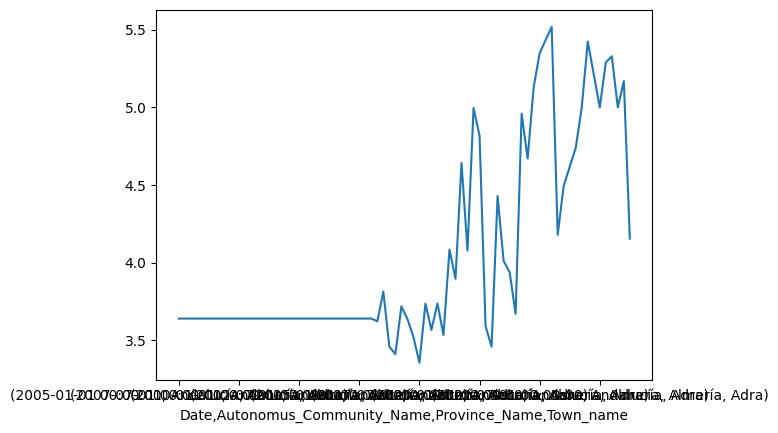

In [24]:
# Filtering based on the 'Province_Name' level in the index
filtered_df = rent_sqm.loc[rent_sqm.index.get_level_values('Town_name') == 'Adra']

# Display the filtered DataFrame
clean = clean_and_interpolate(filtered_df['Rent_per_sqm']).to_frame()

clean['Rent_per_sqm'].plot()

In [25]:
# List of DataFrames to process
dfs_to_clean = [price_sqm, rent_sqm]

clean_dfs = []

# Loop through each DataFrame
for df in dfs_to_clean:
    # Extract unique values from the second level of the index (Town_name or Province_Name)
    unique_values = df.index.get_level_values(3).unique()

    # Initialize an empty DataFrame to store the results for the current DataFrame
    df_results = pd.DataFrame()

    # Loop through each unique value and apply the outlier removal and interpolation
    for value in unique_values:
        # Filter the DataFrame for the current value
        filtered_df = df.loc[df.index.get_level_values(3) == value].copy()

        # Perform outlier removal and interpolation for the first column
        filtered_df.iloc[:, 0] = clean_and_interpolate(filtered_df.iloc[:, 0])

        # Append the result to the DataFrame for the current value
        df_results = pd.concat([df_results, filtered_df])

    # Ensure the results DataFrame has the same order as the original
    df_results = df_results.sort_index()

    # Append the processed DataFrame to the list of results
    clean_dfs.append(df_results)

In [30]:
clean_dfs[0]

Price_per_sqm
Date       Autonomus_Community_Name Province_Name Town_name                               
2005-01-01 Andalucía                Almería       Abrucena                          842.42
                                                  Albox                            1265.81
                                                  Albánchez                         942.67
                                                  Alhama de Almería                1130.17
                                                  Almería                          2008.98
...                                                                                    ...
2023-10-01 Región de Murcia         Murcia        Totana                           1000.00
                                                  Unión (La)                        933.33
                                                  Villanueva del Río Segura         852.62
                                                  Yecla                             743.36
                                                  Águilas                          1237.50

[214624 rows x 1 columns]

In [31]:
price_sqm.to_csv('price_sqm.csv')

In [32]:
# List of DataFrames to process
performance_dfs = [price_sqm, rent_sqm]

performance_dfs_names = ['price_sqm', 'rent_sqm']

results_dfs = []

# Loop through each DataFrame and its corresponding name in performance_dfs and performance_dfs_names
for df_name, df in zip(performance_dfs_names, performance_dfs):
    # Extract unique values from the second level of the index (Town_name or Province_Name)
    unique_values = df.index.get_level_values(3).unique()
    
    # Initialize an empty DataFrame to store the results for the current DataFrame
    df_results = pd.DataFrame()

    # Loop through each unique value and calculate the CAGRs
    for value in unique_values:
        # Filter the DataFrame for the current value
        filtered_df = df.loc[df.index.get_level_values(3) == value].copy()
        
        # Calculate 1-year CAGR (4 periods for quarterly data)
        filtered_df[f'1y_CAGR_{df_name}'] = calculate_cagr(filtered_df.iloc[:, 0], periods=4)
        
        # Calculate 5-year CAGR (20 periods for quarterly data)
        filtered_df[f'5y_CAGR_{df_name}'] = calculate_cagr(filtered_df.iloc[:, 0], periods=20)
        
        # Append the result to the DataFrame for the current value
        df_results = pd.concat([df_results, filtered_df])

    # Ensure the results DataFrame has the same order as the original
    df_results = df_results.sort_index()
    
    # Append the processed DataFrame to the list of results
    results_dfs.append(df_results)

In [35]:
price_sqm = results_dfs[0]
rent_sqm = results_dfs[1]

In [37]:
# Names corresponding to the DataFrames
transaction_dfs = [housing_transactions, housing_transactions]
transaction_dfs_names = ['housing_transactions', 'housing_transactions']

transaction_result_dfs = []

for df_name, df in zip(transaction_dfs_names, transaction_dfs):
    
    unique_values = df.index.get_level_values(3).unique()
    
    df_results = pd.DataFrame()
    
    for value in unique_values:
        filtered_df = df.loc[df.index.get_level_values(3) == value].copy()

        filtered_df.loc[:, f'1y_Change_{df_name}'] = filtered_df.iloc[:, 0].pct_change(periods=4)
        filtered_df.loc[:, f'3y_Change_{df_name}'] = filtered_df.iloc[:, 0].pct_change(periods=12)

        df_results = pd.concat([df_results, filtered_df])
    
    df_results = df_results.sort_index()

    transaction_result_dfs.append(df_results)


In [40]:
housing_transactions = transaction_result_dfs[0]

In [38]:
default_dfs = [default_risk]
default_dfs_names = ['default_risk']

default_results_dfs = []

for df_name, df in zip(default_dfs_names, default_dfs):

    unique_values = df.index.get_level_values(3).unique()

    df_results = pd.DataFrame()

    for value in unique_values:

        filtered_df = df.loc[df.index.get_level_values(3) == value].copy()

        filtered_df.loc[:, f'3y_Change_{df_name}'] = filtered_df.iloc[:, 0] - filtered_df.iloc[:, 0].shift(12)

        df_results = pd.concat([df_results, filtered_df])
    
    df_results = df_results.sort_index()
    
    default_results_dfs.append(df_results)



In [43]:
default_risk = default_results_dfs[0]

In [378]:
town_price_sqm_performance = results_dfs[0]
town_rent_sqm_performance = results_dfs[1]

province_price_sqm_performance = results_dfs[2]
province_rent_sqm_performance = results_dfs[3]

town_housing_transaction_change = transaction_result_dfs[0]
province_housing_transaction_change = transaction_result_dfs[1]

town_default_risk_change = default_results_dfs[0]
province_default_risk_change = default_results_dfs[1]

Time_to_Sell
Date       Autonomus_Community_Name Province_Name Town_name                              
2019-01-01 Andalucía                Almería       Abla                                NaN
                                                  Abrucena                            NaN
                                                  Adra                              5.715
                                                  Alboloduy                           NaN
                                                  Albox                             4.860
...                                                                                   ...
2023-10-01 Región de Murcia         Murcia        Ulea                             64.000
                                                  Unión (La)                       28.000
                                                  Villanueva del Río Segura        45.000
                                                  Yecla                            27.000
                                                  Águilas                          23.000

[163740 rows x 1 columns]

In [52]:
liquidity_dfs = [time2sell, time2rent]
liquidity_dfs_names = ['time2sell', 'time2rent']
l_dfs = []

for df_name, df in zip(liquidity_dfs_names, liquidity_dfs):

    unique_values = df.index.get_level_values(3).unique()

    df_results = pd.DataFrame()

    for value in unique_values:

        filtered_df = df.loc[df.index.get_level_values(3) == value].copy()

        filtered_df.loc[:, f'3y_Change_{df_name}'] = filtered_df.iloc[:, 0] - filtered_df.iloc[:, 0].shift(12)

        df_results = pd.concat([df_results, filtered_df])
    
    df_results = df_results.sort_index()
    
    l_dfs.append(df_results)

In [55]:
time2sell = l_dfs[0]
time2rent = l_dfs[1]

In [58]:
price_sqm.to_excel('3.price_sqm.xlsx')
rent_sqm.to_excel('3.rent_sqm.xlsx')
housing_transactions.to_excel('3.housing_transactions.xlsx')
default_risk.to_excel('3.default_risk.xlsx')
time2sell.to_excel('3.time2sell.xlsx')
time2rent.to_excel('3.time2rent.xlsx')

# Super Dataframe

In [60]:
df1_reset = price_sqm.copy().reset_index()
df2_reset = rent_sqm.copy().reset_index()
df3_reset = housing_transactions.copy().reset_index()
df4_reset = default_risk.copy().reset_index()
df5_reset = time2sell.copy().reset_index()
df6_reset = time2rent.copy().reset_index()

# Perform the inner join based on 'Town_name'
merge_1 = pd.merge(df1_reset, df2_reset, on=['Autonomus_Community_Name', 'Province_Name', 'Town_name', 'Date'], how='inner')
merge_2 = pd.merge(merge_1, df3_reset, on=['Autonomus_Community_Name', 'Province_Name', 'Town_name', 'Date'], how='left')
merge_3 = pd.merge(merge_2, df4_reset, on=['Autonomus_Community_Name', 'Province_Name', 'Town_name', 'Date'], how='left')
merge_4 = pd.merge(merge_3, df5_reset, on=['Autonomus_Community_Name', 'Province_Name', 'Town_name', 'Date'], how='left')
super_df = pd.merge(merge_4, df6_reset, on=['Autonomus_Community_Name', 'Province_Name', 'Town_name', 'Date'], how='left')


# Set the index back to ['Date', 'Town_name'] if needed
super_df.set_index(['Date', 'Autonomus_Community_Name', 'Province_Name', 'Town_name'], inplace=True)

In [63]:
super_df.to_excel('1.super_df.xlsx')

In [68]:
super_df.index

MultiIndex([('2005-01-01',        'Andalucía', 'Almería', ...),
            ('2005-01-01',        'Andalucía', 'Almería', ...),
            ('2005-01-01',        'Andalucía', 'Almería', ...),
            ('2005-01-01',        'Andalucía', 'Almería', ...),
            ('2005-01-01',        'Andalucía', 'Almería', ...),
            ('2005-01-01',        'Andalucía', 'Almería', ...),
            ('2005-01-01',        'Andalucía', 'Almería', ...),
            ('2005-01-01',        'Andalucía', 'Almería', ...),
            ('2005-01-01',        'Andalucía', 'Almería', ...),
            ('2005-01-01',        'Andalucía', 'Almería', ...),
            ...
            ('2023-10-01', 'Región de Murcia',  'Murcia', ...),
            ('2023-10-01', 'Región de Murcia',  'Murcia', ...),
            ('2023-10-01', 'Región de Murcia',  'Murcia', ...),
            ('2023-10-01', 'Región de Murcia',  'Murcia', ...),
            ('2023-10-01', 'Región de Murcia',  'Murcia', ...),
            ('2023-10-01

In [66]:
# Filtering based on the 'Province_Name' level in the index
filtered_df = super_df.loc[super_df.index.get_level_values('Town_name') == 'Abrera']

# Display the filtered DataFrame
max_threshold = filtered_df['1y_CAGR_price_sqm'].quantile(0.90)
min_threshold = filtered_df['1y_CAGR_price_sqm'].quantile(0.10)

# Apply the filter with the correct syntax
filtered_df = filtered_df.mask((filtered_df['1y_CAGR_price_sqm'] < min_threshold) | 
                          (filtered_df['1y_CAGR_price_sqm'] > max_threshold), np.nan)

filtered_df['1y_CAGR_price_sqm'].interpolate(method='linear', inplace=True)

<Axes: xlabel='Date,Autonomus_Community_Name,Province_Name,Town_name'>

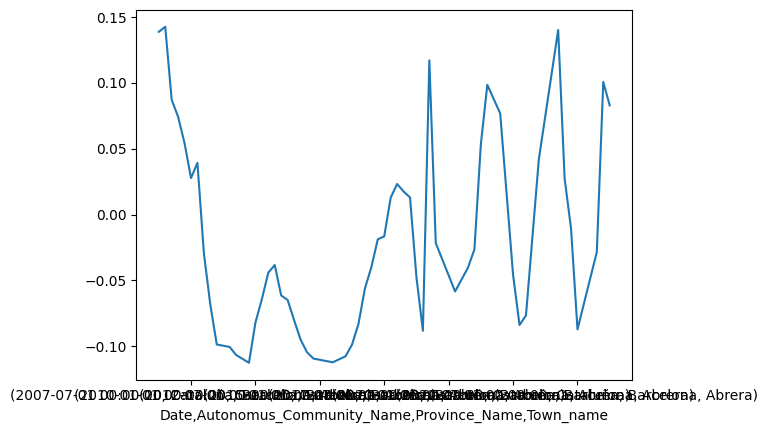

In [67]:
filtered_df['1y_CAGR_price_sqm'].plot()

In [69]:
# Function to clean and interpolate based on thresholds
def clean_and_interpolate_cagr(series, max_threshold, min_threshold):
    series = series.mask((series < min_threshold) | (series > max_threshold), np.nan)
    return series.interpolate(method='linear')

# List of DataFrames to process
dfs_to_clean = [super_df]
clean_dfs = []

# Loop through each DataFrame
for df in dfs_to_clean:
    # Extract unique values from the second level of the index (Town_name or Province_Name)
    unique_values = df.index.get_level_values(3).unique()

    # Initialize an empty DataFrame to store the results for the current DataFrame
    df_results = pd.DataFrame()

    # Loop through each unique value and apply the outlier removal and interpolation
    for value in unique_values:
        # Filter the DataFrame for the current value
        filtered_df = df.loc[df.index.get_level_values(3) == value].copy()
        
        # Define the thresholds based on quantiles
        max_threshold = filtered_df['1y_CAGR_price_sqm'].quantile(0.90)
        min_threshold = filtered_df['1y_CAGR_price_sqm'].quantile(0.10)

        # Apply the cleaning and interpolation
        filtered_df['1y_CAGR_price_sqm'] = clean_and_interpolate_cagr(
            filtered_df['1y_CAGR_price_sqm'], max_threshold, min_threshold
        )

        # Append the result to the DataFrame for the current value
        df_results = pd.concat([df_results, filtered_df])

    # Ensure the results DataFrame has the same order as the original
    df_results = df_results.sort_index()

    # Append the processed DataFrame to the list of results
    clean_dfs.append(df_results)



In [71]:
super_df = clean_dfs[0]

In [72]:
super_df.to_excel('1.super_df.xlsx')

In [73]:
super_df

Price_per_sqm  \
Date       Autonomus_Community_Name Province_Name Town_name                                  
2005-01-01 Andalucía                Almería       Abrucena                          842.42   
                                                  Albox                            1265.81   
                                                  Albánchez                         942.67   
                                                  Alhama de Almería                1130.17   
                                                  Almería                              NaN   
...                                                                                    ...   
2023-10-01 Región de Murcia         Murcia        Totana                           1000.00   
                                                  Unión (La)                        933.33   
                                                  Villanueva del Río Segura         852.62   
                                                  Yecla                             743.36   
                                                  Águilas                          1237.50   

                                                                             1y_CAGR_price_sqm  \
Date       Autonomus_Community_Name Province_Name Town_name                                      
2005-01-01 Andalucía                Almería       Abrucena                                 NaN   
                                                  Albox                                    NaN   
                                                  Albánchez                                NaN   
                                                  Alhama de Almería                        NaN   
                                                  Almería                                  NaN   
...                                                                                        ...   
2023-10-01 Región de Murcia         Murcia        Totana                              0.014816   
                                                  Unión (La)                          0.062826   
                                                  Villanueva del Río Segura           0.070650   
                                                  Yecla                               0.029435   
                                                  Águilas                             0.060711   

                                                                             5y_CAGR_price_sqm  \
Date       Autonomus_Community_Name Province_Name Town_name                                      
2005-01-01 Andalucía                Almería       Abrucena                                 NaN   
                                                  Albox                                    NaN   
                                                  Albánchez                                NaN   
                                                  Alhama de Almería                        NaN   
                                                  Almería                                  NaN   
...                                                                                        ...   
2023-10-01 Región de Murcia         Murcia        Totana                              0.010110   
                                                  Unión (La)                          0.015957   
                                                  Villanueva del Río Segura          -0.047050   
                                                  Yecla                               0.048286   
                                                  Águilas                             0.034494   

                                                                             Rent_per_sqm  \
Date       Autonomus_Community_Name Province_Name Town_name                                 
2005-01-01 Andalucía                Almería       Abrucena                            NaN   
                         

# Feature Engineering

### Price to Rent Ratio

In [78]:
super_dfs = [super_df]

fe_dfs = []

for df in super_dfs:
    
    unique_values = df.index.get_level_values(3).unique()

    df_results = pd.DataFrame()

    for value in unique_values:

        # Filter the DataFrame based on the second level index value (e.g., 'Province_Name' or 'Town_Name')
        filtered_df = df.loc[df.index.get_level_values(3) == value].copy()
        
        # Correctly calculate Price_to_Rent_Ratio using .loc instead of .iloc
        filtered_df.loc[:, 'Rent_Yield'] = (filtered_df.loc[:, 'Rent_per_sqm'] * 12 / filtered_df.loc[:, 'Price_per_sqm']) * 100
        
        # Fill missing values in the 'Price_to_Rent_Ratio' column
        filtered_df['Rent_Yield'].fillna(filtered_df['Rent_Yield'].mean(), inplace=True)
        
        # Calculate the 5-year percentage change for Price_to_Rent_Ratio
        filtered_df.loc[:, '5y_Change_Rent_Yield'] = filtered_df['Rent_Yield'].pct_change(periods=20)

        # Concatenate the results back to df_results
        df_results = pd.concat([df_results, filtered_df])
    
    # Ensure that the DataFrame is sorted and the index format remains consistent
    df_results.sort_index(inplace=True)
    
    fe_dfs.append(df_results)


In [80]:
super_df = fe_dfs[0]

In [82]:
super_dfs = [super_df]

fe_dfs = []

for df in super_dfs:
    
    unique_values = df.index.get_level_values(3).unique()  

    df_results = pd.DataFrame()

    for value in unique_values:

        # Filter the DataFrame based on the third level index value
        filtered_df = df.loc[df.index.get_level_values(3) == value].copy()
        
        # Calculate Transaction Volume (€)
        filtered_df.loc[:, 'Capital Flow in (€)'] = filtered_df.loc[:, 'Price_per_sqm'] * filtered_df.loc[:, 'Housing_Transactions']
        
        # Fill missing values in 'Transaction_Volume_Euros'
        filtered_df['Capital Flow in (€)'].fillna(filtered_df['Capital Flow in (€)'].mean(), inplace=True)
        
        # Calculate the 5-year percentage change for Transaction Volume (€)
        filtered_df.loc[:, '5y_Change_Capital Flow in (€)'] = filtered_df['Capital Flow in (€)'].pct_change(periods=20)

        # Concatenate the results back to df_results
        df_results = pd.concat([df_results, filtered_df])
    
    # Ensure that the DataFrame is sorted and the index format remains consistent
    df_results.sort_index(inplace=True)
    
    fe_dfs.append(df_results)


In [84]:
super_df = fe_dfs[0]

In [86]:
super_df.to_excel('1.super_df.xlsx')